In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [3]:
print(tf.__version__)

2.1.0


In [4]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [5]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()



In [7]:
train_data= pd.read_csv("G:\\Datascience_experiments\\tweet-sentiment-extraction\\train.csv")
train_data.dropna(axis = 0, how ='any',inplace=True) 
train_data['Num_words_text'] = train_data['text'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()


train_data['text'] = train_data['text'].apply(remove_emoji)
train_data['text'] = train_data['text'].apply(remove_url)
train_data['text'] = train_data['text'].apply(clean_text)


test_data= pd.read_csv("G:\\Datascience_experiments\\tweet-sentiment-extraction\\test.csv")
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['text'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['text'] = test_data['text'].apply(remove_emoji)
test_data['text'] = test_data['text'].apply(remove_url)
test_data['text'] = test_data['text'].apply(clean_text)


print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Train data--------
neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64
26752
-------------------------
-------Test data--------
neutral     1376
positive    1075
negative     983
Name: sentiment, dtype: int64
3434
-------------------------
Train Max Sentence Length :33
Test Max Sentence Length :32


In [8]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['text'].tolist())


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

   


[[1, 58, 21, 4]]


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['text'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.1,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['text'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=40)
x_valid = pad_sequences(x_valid, padding='post', maxlen=40)
x_test = pad_sequences(x_test, padding='post', maxlen=40)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


Train data len:24076
Class distributionCounter({'neutral': 9633, 'positive': 7537, 'negative': 6906})
Valid data len:2676
Class distributionCounter({'neutral': 1071, 'positive': 838, 'negative': 767})


G:\New folder\envs\pyfor\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
G:\New folder\envs\pyfor\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
G:\New folder\envs\pyfor\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

[  23    4    9   25    2    1   24  823  158    1  173    1 8795 6293
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [10]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['positive', 'positive', 'neutral', 'negative', 'neutral', 'negative', 'positive', 'positive', 'positive', 'neutral']
Text to number
[2 2 1 0 1 0 2 2 2 1]
Number to category
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [11]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break  

======Train dataset ====
tf.Tensor(
[  23    4    9   25    2    1   24  823  158    1  173    1 8795 6293
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[3598    2 2100  124  557   21  543   18  101    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[ 117 4681    3  271   19 3693   90    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
======Validation dataset ====
tf.Tensor(
[  189    94    20  1512   104     7   474    14   423   295 

In [12]:
max_features =20000
embedding_dim =64
sequence_length = 40

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(3, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                               



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 64)            1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 38, 128)           24704     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
_________________________________________________________________


In [13]:
epochs = 100
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Train for 189 steps, validate for 21 steps
Epoch 1/100


G:\New folder\envs\pyfor\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
G:\New folder\envs\pyfor\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


189/189 [==============================] - 16s 86ms/step - loss: 1.1148 - CategoricalAccuracy: 0.4752 - val_loss: 0.9808 - val_CategoricalAccuracy: 0.5632
Epoch 2/100
189/189 [==============================] - 13s 71ms/step - loss: 0.9795 - CategoricalAccuracy: 0.5742 - val_loss: 0.9613 - val_CategoricalAccuracy: 0.6383
Epoch 3/100
189/189 [==============================] - 13s 69ms/step - loss: 0.9553 - CategoricalAccuracy: 0.6588 - val_loss: 0.9367 - val_CategoricalAccuracy: 0.7007
Epoch 4/100
189/189 [==============================] - 13s 67ms/step - loss: 0.9433 - CategoricalAccuracy: 0.6861 - val_loss: 0.9321 - val_CategoricalAccuracy: 0.7037
Epoch 5/100
189/189 [==============================] - 13s 67ms/step - loss: 0.9371 - CategoricalAccuracy: 0.6947 - val_loss: 0.9335 - val_CategoricalAccuracy: 0.7093
Epoch 6/100
189/189 [==============================] - 13s 67ms/step - loss: 0.9353 - CategoricalAccuracy: 0.7014 - val_loss: 0.9277 - val_CategoricalAccuracy: 0.7104
Epoch 7/10

In [14]:
history.history

{'loss': [1.115251256770362,
  0.9801523723085768,
  0.9556236254414325,
  0.9433134395352509,
  0.9370789975299255,
  0.9344100368678481,
  0.9334786347048408,
  0.9320148413294989,
  0.9315141611349584,
  0.9311133582918009,
  0.9301778557273236,
  0.9285505024831068,
  0.928844233261507,
  0.9281672573620386,
  0.9278053286899897,
  0.92800482492111,
  0.927528411194541,
  0.926833149661533,
  0.9255890634135563,
  0.9260817275013237,
  0.9264032884696964,
  0.9265122136655372,
  0.9254110922328577,
  0.9249556114515567,
  0.9252957174559728,
  0.9249440233143763,
  0.9235440069683606,
  0.9248999456052943,
  0.9239749363796084,
  0.9236005630519307,
  0.9230447564831721,
  0.9225990936930026,
  0.9231838495613709,
  0.9234528804879031,
  0.9224682054877736,
  0.922078312423701,
  0.9216009084915754,
  0.9220479030826199,
  0.9210062071638936,
  0.922236147028284,
  0.9216486601798632,
  0.9207246748785933,
  0.921310187425897,
  0.9214085595594685,
  0.9207721532807237,
  0.9215447

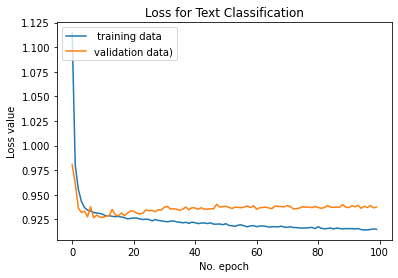

In [15]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

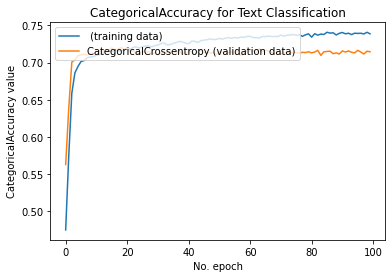

In [16]:
plt.plot(history.history['CategoricalAccuracy'], label=' (training data)')
plt.plot(history.history['val_CategoricalAccuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [17]:
model.save('G:\\Datascience_experiments\\tweet-sentiment-extraction\\tf_cnnmodel') 
json_string = tokenizer.to_json()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: G:\Datascience_experiments\tweet-sentiment-extraction\tf_cnnmodel\assets


In [19]:
model.save('G:\\Datascience_experiments\\tweet-sentiment-extraction\\tf_nlp_cnnmodel') 

In [20]:
import json
with open('G:\\Datascience_experiments\\tweet-sentiment-extraction\\tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [22]:
new_model = tf.keras.models.load_model('G:\\Datascience_experiments\\tweet-sentiment-extraction\\tf_cnnmodel')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 64)            1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 38, 128)           24704     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
_________________________________________________________________


In [23]:
with open('G:\\Datascience_experiments\\tweet-sentiment-extraction\\tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [24]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['text'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=40)

G:\New folder\envs\pyfor\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [25]:
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
[[0.15162018 0.9178299  0.1394088 ]
 [0.00370184 0.04365836 0.97777927]
 [0.9774588  0.08691884 0.00531968]
 ...
 [0.77381516 0.47116783 0.0244188 ]
 [0.00146439 0.01698755 0.9933515 ]
 [0.00296543 0.03531612 0.9834389 ]]


In [26]:
test_data['pred_sentiment']= predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'negative',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'neutral',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '2'),'positive',test_data.pred_sentiment)


In [28]:
type(test_data['pred_sentiment'])

pandas.core.series.Series

In [29]:
labels = ['positive', 'negative','neutral']
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

    positive       0.75      0.76      0.75      1075
    negative       0.70      0.67      0.69       983
     neutral       0.67      0.69      0.68      1376

    accuracy                           0.70      3434
   macro avg       0.71      0.70      0.71      3434
weighted avg       0.70      0.70      0.70      3434

